# Novel Recombinants Analysis

This notebook contains supplementary analyses of the 929 novel recombinants identified in the `sc2ts` paper.

In [1]:
from pathlib import Path
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nb_utils

In [2]:
data_dir = Path("../data")

In [3]:
#! git clone https://github.com/phac-nml/pangonet.git
#! cd pangonet && pip install . && cd -
#! pangonet --help | head

In [4]:
dataset_dir = Path("dataset")
alias_key_file = dataset_dir / "rebar" / "alias_key.json"
lineage_notes_file = dataset_dir / "rebar" / "lineage_notes.txt"
pangonet = nb_utils.initialise_pangonet(alias_key_file, lineage_notes_file)

2025-04-12 22:05:07,451 INFO:Creating aliases.
2025-04-12 22:05:07,463 INFO:Creating network.


## Compare

### Data

In [5]:
sc2ts_file = data_dir / "recombinants.csv"
df_sc2ts = pd.read_csv(sc2ts_file).set_index("sample_id")
# df_sc2ts.head(5)
len(df_sc2ts)

929

In [6]:
rebar_file = data_dir / "rebar.tsv"
df_rebar = pd.read_csv(rebar_file, sep="\t").set_index("strain")
# df_rebar.head(5)
len(df_rebar)

929

In [7]:
# NOTE: recombinant in the sc2ts file is the recombinant node ID.
dfj = df_sc2ts.join(df_rebar, rsuffix="_rebar")
dfj.columns

Index(['recombinant', 'descendants', 'sample', 'sample_pango', 'interval_left',
       'interval_right', 'num_mutations', 'date_added', 'group_id',
       'parent_left', 'parent_left_pango', 'parent_right',
       'parent_right_pango', 'mrca', 't_mrca', 'diffs', 'max_run_length',
       'max_runlength_3sep', 'likely_artifactual', 'k4_num_mutations',
       'k1000_num_mutations', 'num_mutations_averted', 'validate',
       'validate_details', 'population', 'recombinant_rebar', 'parents',
       'breakpoints', 'edge_case', 'unique_key', 'regions', 'substitutions',
       'genome_length', 'dataset_name', 'dataset_tag', 'cli_version'],
      dtype='object')

### Filter

In [8]:
int(sum(dfj["recombinant_rebar"] == "novel"))

161

Overall, we have 161 recombinants marked as novel by rebar. Is the run_length diagnostic here in terms of picking these out?

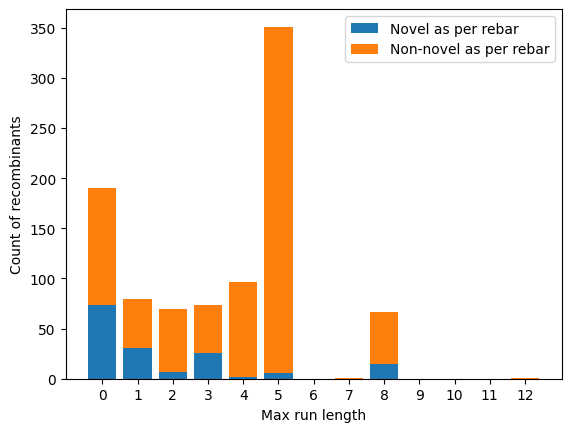

In [9]:
novel_max_run_len = dfj[dfj["recombinant_rebar"] == "novel"].max_run_length
nonnovel_max_run_len = dfj[dfj["recombinant_rebar"] != "novel"].max_run_length

nb_utils.plot_stacked_histogram(
    a=novel_max_run_len,
    b=nonnovel_max_run_len,
    alegend='Novel as per rebar',
    blegend='Non-novel as per rebar',
    xlabel='Max run length',
    ylabel='Count of recombinants',
    xlim=[0, 14],
);

No, as it happens the vast majority of the errors have a run length of 5. So let's exclude these.

In [10]:
df_hq = dfj[dfj.max_run_length != 5]
# df_hq.head(5)
len(df_hq)

578

In [11]:
# Of the filtered sc2ts recombinants, rebar classifies:
# non-recombinants: 355
# novel recombinants: 155
# known recombinants: 68
counts = collections.Counter(df_hq["recombinant_rebar"])
df_counts = pd.DataFrame(
    {
        "lineage": counts.keys(),
        "count": counts.values(),
    }
)\
    .sort_values("count", ascending=False)\
    .set_index("lineage")
df_counts

,count
lineage,
NaN,355
novel,155
XM,7
XS,7
XAS,6
XAN,5
XAB,4
XAP,4
XA,3


In [12]:
df_nonrecomb = df_hq[df_hq["recombinant_rebar"].isna()]
#df_nonrecomb.head(5)
len(df_nonrecomb)

355

In [13]:
df_recomb = df_hq[~df_hq["recombinant_rebar"].isna()]
# df_recomb.head(5)
len(df_recomb)

223

Do any of these recombinants have more than one breakpoint?

In [14]:
df_recomb = df_recomb\
    .assign(num_parents_rebar = [len(x.split(",")) for x in df_recomb["parents"]])\
    .assign(num_breakpoints_rebar = [len(x.split(",")) for x in df_recomb["breakpoints"]])

In [15]:
# How many recombinants have more than 2 parents as per rebar?
sum(df_recomb["num_parents_rebar"] > 2)

0

In [16]:
# How many recombinants have more than 1 breakpoint as per rebar?
sum(df_recomb["num_breakpoints_rebar"] > 1)

7

In [17]:
# 7 recombinants (only 1 novel) have more than one breakpoint. Exclude them.
df_recomb = df_recomb[
    (df_recomb["num_parents_rebar"] == 2) & \
    (df_recomb["num_breakpoints_rebar"] == 1)
]
len(df_recomb)

216

In [18]:
# 3 recombinants have "Unknown (R)" as per sc2ts. Exclude them.
# TODO: Investigate them.
df_recomb = df_recomb[
    (df_recomb["parent_left_pango"] != "Unknown (R)") & \
    (df_recomb["parent_right_pango"] != "Unknown (R)")
]
len(df_recomb)

213

### Disagreement

In [ ]:
# TODO: Revisit.
import copy

df_nonrecomb[
  (df_nonrecomb["num_mutations"] >= 3) & (df_nonrecomb["parent_left_pango"] != df_nonrecomb["parent_right_pango"])
][["parent_left_pango", "parent_right_pango"]]

is_rebar_candidate = [False for _ in range(0, len(df_nonrecomb))]
for i,data in enumerate(df_nonrecomb.iterrows()):
    index, row = data
    if row["num_mutations"] < 3: continue
    # Check for equivalent or sister taxa
    p1, p2 = row["parent_left_pango"], row["parent_right_pango"]
    if p1 == p2: continue
    anc, desc = pangonet.get_ancestors(p1), pangonet.get_descendants(p1)
    if p2 in anc or p2 in desc: continue         
    is_rebar_candidate[i] = True

df_nonrecomb["is_rebar_candidate"] = is_rebar_candidate
df_nonrecomb[df_nonrecomb["is_rebar_candidate"]][["parent_left_pango", "parent_right_pango", "num_mutations"]]

### Compare parent Pango identities

In [19]:
df_recomb = df_recomb\
    .assign(parent_left_rebar = [x.split(",")[0] for x in df_recomb["parents"]])\
    .assign(parent_right_rebar = [x.split(",")[1] for x in df_recomb["parents"]])\
    .assign(breakpoint_left_rebar = [int(x.split("-")[0]) for x in df_recomb["breakpoints"]])\
    .assign(breakpoint_right_rebar = [int(x.split("-")[1]) for x in df_recomb["breakpoints"]])

In [20]:
is_parents_concordant = np.zeros(len(df_recomb), dtype=bool)
i = 0
for index, row in df_recomb.iterrows():
    concordant_count = 0
    for p in ["left", "right"]:
        p_rebar = row[f"parent_{p}_rebar"]
        anc_rebar = pangonet.get_ancestors(p_rebar)
        desc_rebar = pangonet.get_descendants(p_rebar)
        p_sc2ts = row[f"parent_{p}_pango"]

        concordant = (p_rebar == p_sc2ts) or \
            (p_sc2ts in anc_rebar) or \
            (p_sc2ts in desc_rebar)
        # TBD: We could put a distance check here to make sure they're not
        # extremely distant related.
        concordant_count += 1 if concordant else 0

    # If both parents are concordant
    if concordant_count == 2:
        is_parents_concordant[i] = 1
    i +=1
df_recomb = df_recomb.assign(is_parents_concordant = is_parents_concordant)

In [21]:
num_concordant = len(df_recomb[df_recomb['is_parents_concordant']])
perc_concordant = round((num_concordant / len(df_recomb) ) * 100, 1)
print(f"Concordant Parents: {num_concordant}/{len(df_recomb)} ({perc_concordant}%)")

Concordant Parents: 182/213 (85.4%)


In [22]:
pd.set_option('display.max_rows', 100)
df_recomb.loc[
    ~df_recomb["is_parents_concordant"],
    [
        "descendants",
        "sample_pango",
        "parent_left_pango",    # sc2ts
        "parent_left_rebar",
        "parent_right_pango",   # sc2ts
        "parent_right_rebar",
    ]
]

,descendants,sample_pango,parent_left_pango,parent_left_rebar,parent_right_pango,parent_right_rebar
sample_id,,,,,,
ERR5238288,1,B.1.177.9,B.1.1.7,B.1.1.7,B.1.177.9,B.1.177.10
ERR6457057,1,AY.9,AY.4.7,AY.4.2,AY.9.2,AY.9.2
SRR15800623,1,B.1.617.2,B.1.617.2,AY.100,AY.10,AY.67
SRR16063537,21,B.1.617.2,AY.26,AY.11,AY.3,AY.3
SRR15982371,1,B.1.617.2,AY.25,AY.23,AY.26,AY.26
ERR8213432,1,AY.43,AY.43,AY.43,AY.4,AY.86
SRR20940538,2,B.1.617.2,AY.25,AY.121.1,AY.44,AY.87
SRR20358773,1,BA.1.15,AY.25,AY.41,BA.1.15,BA.1.15.3
ERR8691075,152,XQ,BA.1.1.15,BA.1.1,BA.2.9,BA.2.23


### Compare breakpoint intervals

In [23]:
# TODO: Refactor and move to utils.
def overlap_breakpoint_intervals(*, rebar_interval, sc2ts_interval):
    assert rebar_interval[0] < rebar_interval[1]
    assert sc2ts_interval[0] < sc2ts_interval[1]
    # NOTE: rebar reports closed intervals spanning regions ambiguously assigned to parents.
    # Adjust the rebar coordinates so they are comparable to sc2ts.
    rebar_interval_adj = (rebar_interval[0] - 1, rebar_interval[1] + 1)
    rebar_size = rebar_interval_adj[1] - rebar_interval_adj[0]
    sc2ts_size = sc2ts_interval[1] - sc2ts_interval[0]
    def _get_overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))
    overlap_size = _get_overlap(a=rebar_interval_adj, b=sc2ts_interval)
    is_overlap_with_rebar = overlap_size > 0
    overlap_rebar_size_ratio = overlap_size / rebar_size
    sc2ts_rebar_size_ratio = sc2ts_size / rebar_size
    interval_distance = max(
        0,
        max(
            rebar_interval_adj[0] - sc2ts_interval[1],
            sc2ts_interval[0] - rebar_interval_adj[1],
        )
    )
    return (
        is_overlap_with_rebar,
        overlap_rebar_size_ratio,
        sc2ts_rebar_size_ratio,
        interval_distance,
    )


is_overlap_with_rebar = np.zeros(len(df_recomb), dtype=bool)
overlap_rebar_size_ratio = np.zeros(len(df_recomb), dtype=np.float32)
sc2ts_rebar_size_ratio = np.zeros(len(df_recomb), dtype=np.float32)
interval_distance = np.zeros(len(df_recomb), dtype=np.float32)

i = 0
for index, row in df_recomb.iterrows():
    (
        is_overlap_with_rebar[i], 
        overlap_rebar_size_ratio[i], 
        sc2ts_rebar_size_ratio[i],
        interval_distance[i],
    ) = overlap_breakpoint_intervals(
        rebar_interval=(row["breakpoint_left_rebar"], row["breakpoint_right_rebar"]),
        sc2ts_interval=(row["interval_left"], row["interval_right"]),
    )
    i += 1

df_recomb = df_recomb\
    .assign(is_overlap_with_rebar = is_overlap_with_rebar)\
    .assign(overlap_rebar_size_ratio = overlap_rebar_size_ratio)\
    .assign(sc2ts_rebar_size_ratio = sc2ts_rebar_size_ratio)\
    .assign(interval_distance = interval_distance)

df_recomb[
    [
        "interval_left",
        "interval_right",
        "breakpoint_left_rebar",
        "breakpoint_right_rebar",
        "is_overlap_with_rebar",
    ]
]

,interval_left,interval_right,breakpoint_left_rebar,breakpoint_right_rebar,is_overlap_with_rebar
sample_id,,,,,
ERR4437465,8783,13617,8783,14407,True
ERR4615866,15325,21855,15325,20660,True
ERR4671078,22993,25563,22993,25562,True
ERR4786984,27871,27944,26802,27943,True
ERR4793705,22993,25505,22993,25504,True
...,...,...,...,...,...
ERR10839848,19327,20741,18584,20740,True
SRR23358540,9867,12160,11751,12159,True
ERR10931828,19887,21811,19887,21810,True


In [24]:
num_concordant = len(df_recomb[df_recomb['is_overlap_with_rebar']])
perc_concordant = round((num_concordant / len(df_recomb) ) * 100, 1)
print(f"Concordant Breakpoints: {num_concordant}/{len(df_recomb)} ({perc_concordant}%)")

Concordant Breakpoints: 201/213 (94.4%)


In [25]:
# TODO: Refactor and move to utils.
def plot_breakpoint_interval_properties(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 2))
    fig.suptitle(title)
    ax[0].set_ylabel("Number of recombinants")
    ax[0].set_xlabel("Interval overlap size / rebar interval size")
    ax[0].hist(df["overlap_rebar_size_ratio"], bins=30)
    ax[1].set_xlabel("sc2ts interval size / rebar interval size")
    ax[1].hist(df["sc2ts_rebar_size_ratio"], bins=30)
    ax[2].set_xlabel("Distance between intervals")
    ax[2].hist(df["interval_distance"], bins=30, log=True);

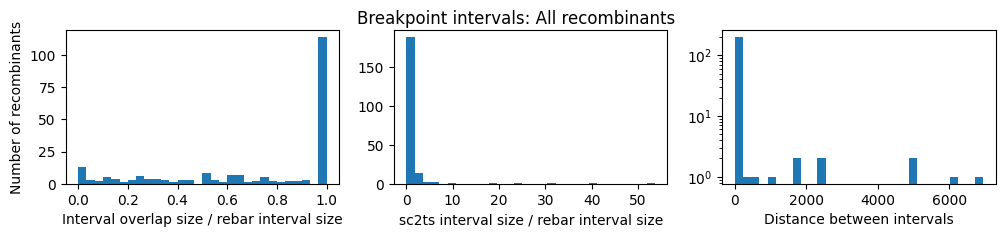

In [26]:
plot_breakpoint_interval_properties(df_recomb, title="Breakpoint intervals: All recombinants")

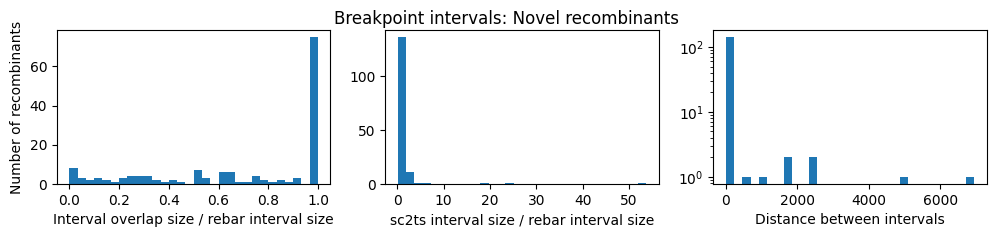

In [27]:
plot_breakpoint_interval_properties(
    df_recomb[df_recomb["recombinant_rebar"] == "novel"],
    title="Breakpoint intervals: Novel recombinants",
)

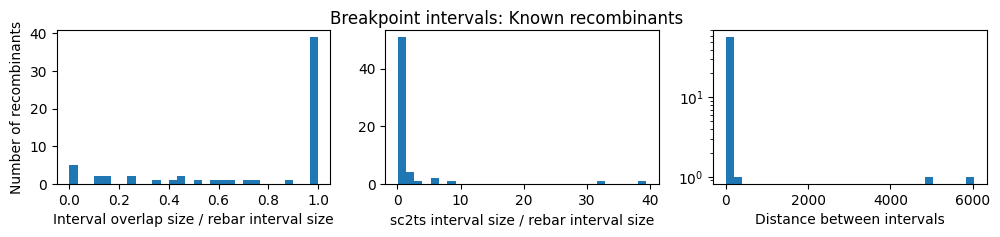

In [28]:
plot_breakpoint_interval_properties(
    df_recomb[df_recomb["recombinant_rebar"] != "novel"],
    title="Breakpoint intervals: Known recombinants",
)

In [29]:
# Cases where the breakpoint intervals do not overlap.
df_recomb.loc[
    ~df_recomb["is_overlap_with_rebar"],
    [
        "sample_pango",
        "recombinant_rebar",
        "descendants",
        "interval_left",
        "interval_right",
        "breakpoint_left_rebar",
        "breakpoint_right_rebar",
        "overlap_rebar_size_ratio",
        "sc2ts_rebar_size_ratio",
        "interval_distance",
    ]
].sort_values(by="recombinant_rebar")

,sample_pango,recombinant_rebar,descendants,interval_left,interval_right,breakpoint_left_rebar,breakpoint_right_rebar,overlap_rebar_size_ratio,sc2ts_rebar_size_ratio,interval_distance
sample_id,,,,,,,,,,
ERR9755541,BA.2,XAB,36,10199,10447,9535,10197,0.0,0.373494,1.0
ERR9909297,BA.5.1,XAN,1,18569,21767,9867,12524,0.0,1.202708,6044.0
ERR10462353,XBB,XBB,6455,22332,22577,22897,22941,0.0,5.326087,319.0
ERR10933490,XBB.1.5.4,XBB,2,27916,29729,22897,22941,0.0,39.413044,4974.0
SRR16063537,B.1.617.2,novel,21,21319,22227,13020,19515,0.0,0.139757,1803.0
ERR7273201,AY.4,novel,2,17041,19220,21615,25332,0.0,0.585910,2394.0
SRR20940538,B.1.617.2,novel,2,14015,14818,19816,19858,0.0,18.250000,4997.0
SRR19942335,BA.2,novel,1,15010,21721,22793,22916,0.0,53.688000,1071.0
ERR10019912,BA.5.1,novel,4,13612,17750,24701,25854,0.0,3.582684,6950.0


### Explore sensitivity between sc2ts and rebar

In [30]:
node_dist = []
for i, row in df_hq.iterrows():
    if row["parent_left_pango"] == "Unknown (R)" or row["parent_right_pango"] == "Unknown (R)":
        node_dist.append(-1)
        continue
    if row["parent_left_pango"].startswith("X") or row["parent_right_pango"].startswith("X"):
        node_dist.append(-1)
        continue
    d = nb_utils.get_node_distance(
        pangonet=pangonet,
        label_1=row["parent_left_pango"],
        label_2=row["parent_right_pango"],
    )
    node_dist.append(d)

In [31]:
# Exclude these cases.
len([x for x in node_dist if x == -1])

12

In [32]:
df_hq_nd = df_hq.assign(node_distance=node_dist)
df_hq_nd = df_hq_nd[df_hq_nd["node_distance"] >= 0]
df_hq_nd.head(1)

,recombinant,descendants,sample,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,parent_left,...,breakpoints,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version,node_distance
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR4437465,1530,1,1529,B.1.157,8783,13617,2,2020-03-22,052b938d3189a1c873abd3ffd894e4c6,1121,...,8783-14407,False,novel_A_B.1_8783-14407,"241-8782|A,14408-23403|B.1","C8782T|A;C14408T,A20268G,A23403G|B.1;C850T,C64...",29903,sars-cov-2,2025-01-28,0.2.0,5


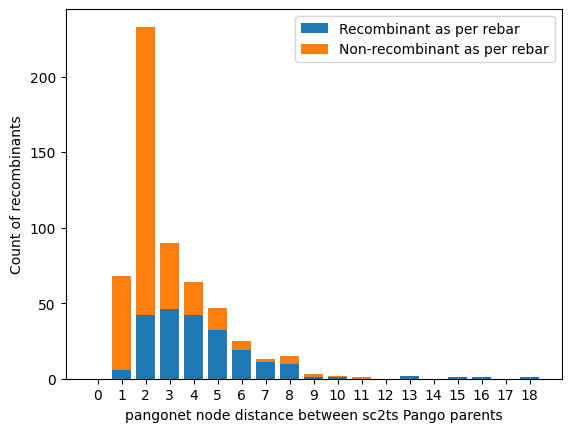

In [33]:
recomb_nd = df_hq_nd[~df_hq_nd["recombinant_rebar"].isna()].node_distance
nonrecomb_nd = df_hq_nd[df_hq_nd["recombinant_rebar"].isna()].node_distance

nb_utils.plot_stacked_histogram(
    a=recomb_nd,
    b=nonrecomb_nd,
    alegend='Recombinant as per rebar',
    blegend='Non-recombinant as per rebar',
    xlabel='pangonet node distance between sc2ts Pango parents',
    ylabel='Count of recombinants',
    xlim=[0, 20],
);

### Explore relationship with number of averted mutations

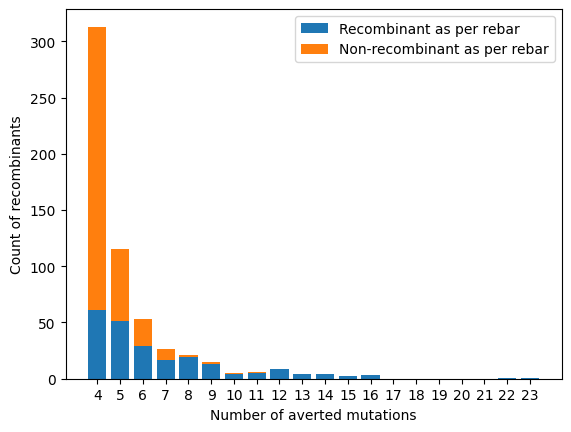

In [34]:
is_rebar_recomb = df_hq["recombinant_rebar"].isna()
rebar_nonrecomb = df_hq[is_rebar_recomb].num_mutations_averted
rebar_recomb = df_hq[~is_rebar_recomb].num_mutations_averted

nb_utils.plot_stacked_histogram(
    a=rebar_recomb,
    b=rebar_nonrecomb,
    alegend='Recombinant as per rebar',
    blegend='Non-recombinant as per rebar',
    xlabel='Number of averted mutations',
    ylabel='Count of recombinants',
    xlim=[4, 25],
);

## Summary

### Recombinants

- There are 213 recombinants detected by both `rebar` and `sc2ts`.
- 182/213 (85.4%) have concordant parents, based on a non-sister taxa relationship.
- 201/213 (94.4%) have overlapping breakpoints.
- Parents that are not concordant tend to be close sister taxa (ex. `BA.5.2.21` vs. `BA.5.2.6`).

### Non-Recombinants

- There are 355 recombinants detected by `sc2ts` but not `rebar`.
- Only 23/355 are rebar candidates (based on number of mutations, parents as sister taxa).